# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Nabila Alawiyah
- **Email:** nabilaalawiyah.25@gmail.com
- **ID Dicoding:** nabila_alawiyah_B1OF

# Keterangan

* Dataset ini

# Saran

* Mengimplementasikan Callback
* Gambar-gambar pada dataset asli memiliki resolusi yang tidak seragam (Tanpa preprocessing) : **Done. Data asli memiliki resolusi yang tidak seragam dengan jumlah data 23.862**
* Dataset yang digunakan berisi minimal 10000 gambar.
* Akurasi pada training set dan testing set minimal 95%.
* Memiliki 3 buah kelas atau lebih.
* Melakukan inference menggunakan salah satu model (TF-Lite, TFJS atau savedmodel)

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [2]:
# disediakan google colab untuk kebutuhan upload file json akun
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nabilaalawiyah","key":"dcd050a2bc371d275fa6f8d24143a79f"}'}

In [3]:
# Membuat folder .kaggle dan memindahkan file json ke sana
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d harishkumardatalab/food-image-classification-dataset
!unzip -q food-image-classification-dataset.zip -d /content/food

Dataset URL: https://www.kaggle.com/datasets/harishkumardatalab/food-image-classification-dataset
License(s): CC0-1.0


In [5]:
!ls /content/food

'Food Classification dataset'


In [40]:
import os
import shutil

# Direktori awal dari folder dataset makanan
source_dir = "/content/food/Food Classification dataset"

# Direktori target untuk menggabungkan seluruh gambar
combined_dir = "/content/food/dataset2"
os.makedirs(combined_dir, exist_ok=True)

# Loop melalui setiap folder kategori di direktori sumber
for category in os.listdir(source_dir):
    category_dir = os.path.join(source_dir, category)

    if os.path.isdir(category_dir):
        for filename in os.listdir(category_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # filter file gambar
                src = os.path.join(category_dir, filename)
                dst = os.path.join(combined_dir, filename)  # tanpa nama kategori
                if not os.path.exists(dst):  # hindari overwrite
                    shutil.copy(src, dst)
                else:
                    # Jika ada nama file yang sama, tambahkan angka di belakang
                    base, ext = os.path.splitext(filename)
                    count = 1
                    while True:
                        new_filename = f"{base}_{count}{ext}"
                        new_dst = os.path.join(combined_dir, new_filename)
                        if not os.path.exists(new_dst):
                            shutil.copy(src, new_dst)
                            break
                        count += 1

print("Penggabungan selesai. Semua file sudah dipindahkan ke:", combined_dir)

Penggabungan selesai. Semua file sudah dipindahkan ke: /content/food/dataset2


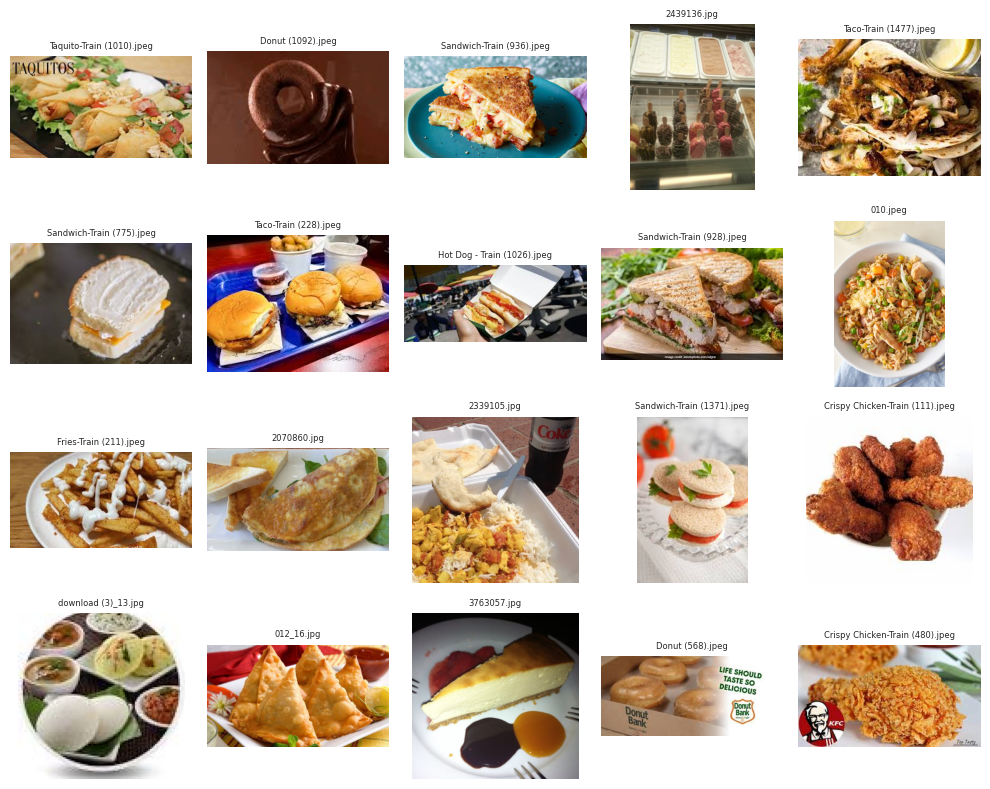

In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Path ke folder gabungan
path = "food/"
path_sub = os.path.join(path, "dataset2")

# Ambil semua file gambar
image_files = [f for f in os.listdir(path_sub) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Acak dan ambil subset
np.random.shuffle(image_files)
num_images = min(20, len(image_files))  # ambil maksimal 20 gambar

# Tentukan ukuran grid visualisasi
cols = 5
rows = (num_images // cols) + (num_images % cols > 0)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axs = axs.flatten()

for idx in range(num_images):
    img_path = os.path.join(path_sub, image_files[idx])
    img = Image.open(img_path)

    axs[idx].imshow(img)
    axs[idx].set_title(image_files[idx], fontsize=6)
    axs[idx].axis('off')

# Matikan axis kosong
for j in range(num_images, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


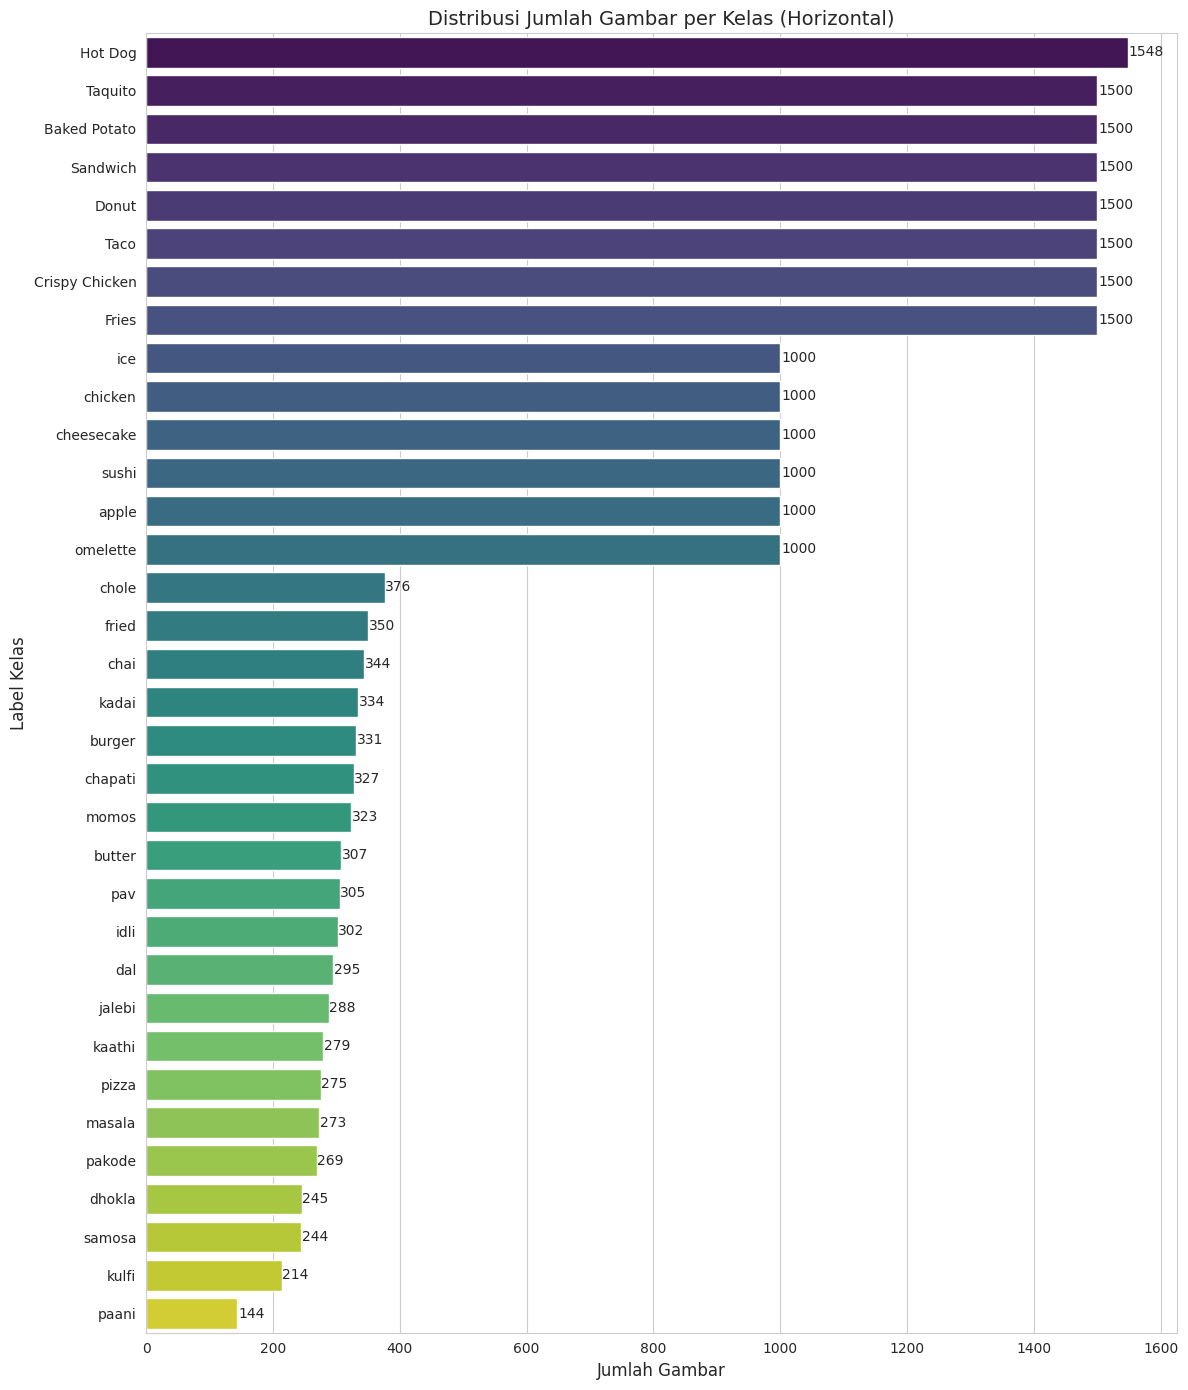

In [38]:
# Path ke direktori dataset
food_path = "food/dataset"

# Inisialisasi list
file_name = []
labels = []
full_path = []

# Ambil data dari nama file
for name in os.listdir(food_path):
    if name.lower().endswith(('.jpg', '.jpeg', '.png')):
        label = name.split('_')[0]  # Ambil nama kelas dari nama file
        labels.append(label)
        file_name.append(name)
        full_path.append(os.path.join(food_path, name))

# Buat DataFrame
distribution_train = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Hitung jumlah gambar per label
label_counts = distribution_train['labels'].value_counts()

# Plot distribusi dengan orientasi horizontal
plt.figure(figsize=(12, 14))  # Ukuran diperbesar agar label tidak terpotong
sns.set_style("whitegrid")
barplot = sns.barplot(
    y=label_counts.index,
    x=label_counts.values,
    palette="viridis"
)

# Tambahkan label jumlah di ujung setiap bar
for index, value in enumerate(label_counts.values):
    barplot.text(value + 1, index, str(value), va='center')

plt.title("Distribusi Jumlah Gambar per Kelas (Horizontal)", fontsize=14)
plt.xlabel("Jumlah Gambar", fontsize=12)
plt.ylabel("Label Kelas", fontsize=12)
plt.tight_layout()
plt.show()

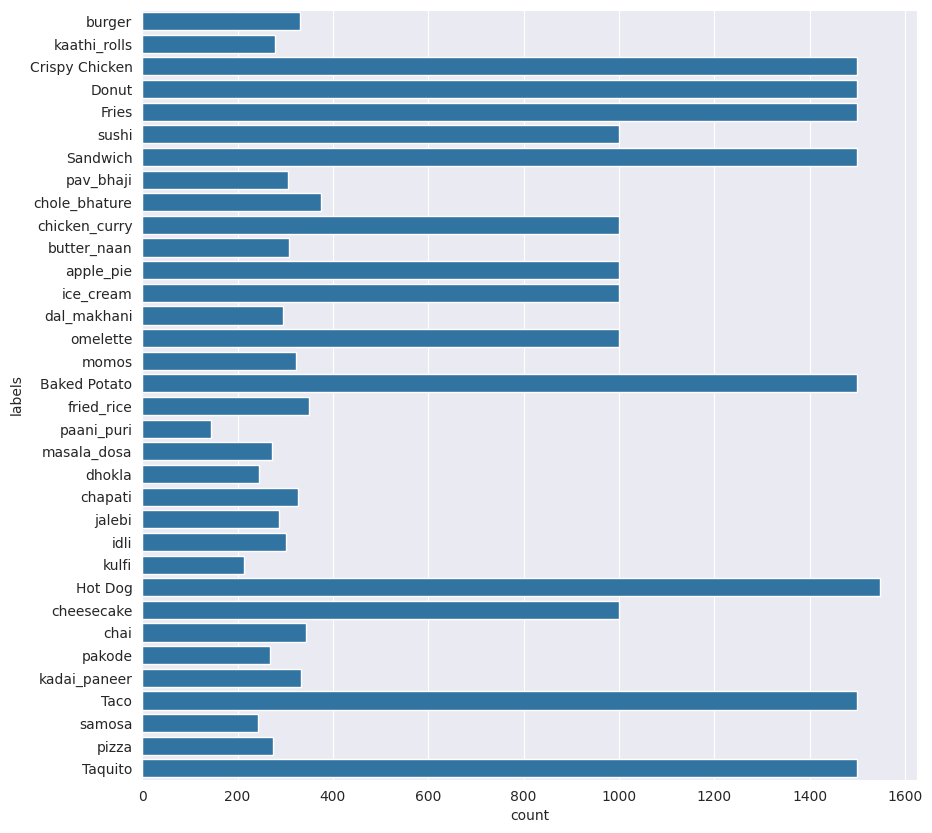

In [36]:
# Define source path
food_path = "food/Food Classification dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(food_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (10,10))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

In [8]:
# Daftar untuk menyimpan data
data = []

# Iterasi melalui setiap folder (colorless,fairy,fighting,fire,grass,lightning,pyshic)
for label in os.listdir(food_path):
    label_dir = os.path.join(food_path, label)

    if os.path.isdir(label_dir):
        # Iterasi melalui setiap gambar dalam folder
        for filename in os.listdir(label_dir):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Ganti ekstensi jika perlu
                filepath = os.path.join(label_dir, filename)
                data.append({'filename': filename, 'filepath': filepath, 'label': label})

# Membuat DataFrame
dataset_df = pd.DataFrame(data)

In [9]:
# Fungsi untuk mendapatkan resolusi gambar
def get_image_resolution(filepath):
    try:
        with Image.open(filepath) as img:
            return img.size
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return (None, None)

In [10]:
# Menambahkan kolom resolusi ke dataset_df
dataset_df['resolution'] = dataset_df['filepath'].apply(get_image_resolution)

In [11]:
#menampilkan resolusi dataset dalam dataframe
dataset_df

,filename,filepath,label,resolution
0,080.jpg,food/Food Classification dataset/burger/080.jpg,burger,"(1280, 720)"
1,092.jpg,food/Food Classification dataset/burger/092.jpg,burger,"(560, 560)"
2,169.jpg,food/Food Classification dataset/burger/169.jpg,burger,"(2000, 1500)"
3,189.jpg,food/Food Classification dataset/burger/189.jpg,burger,"(700, 700)"
4,166.jpg,food/Food Classification dataset/burger/166.jpg,burger,"(722, 406)"
...,...,...,...,...
23857,Taquito-Train (1226).jpeg,food/Food Classification dataset/Taquito/Taqui...,Taquito,"(151, 335)"
23858,Taquito-Train (887).jpeg,food/Food Classification dataset/Taquito/Taqui...,Taquito,"(183, 275)"
23859,Taquito-Train (857).jpeg,food/Food Classification dataset/Taquito/Taqui...,Taquito,"(275, 183)"
23860,Taquito-Train (688).jpeg,food/Food Classification dataset/Taquito/Taqui...,Taquito,"(183, 275)"


In [12]:
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(food_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Baked Potato,1500
Crispy Chicken,1500
Donut,1500
Fries,1500
Hot Dog,1548
Sandwich,1500
Taco,1500
Taquito,1500
apple_pie,1000


Data Augmentation

In [25]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))  # Sesuaikan nilai delta sesuai kebutuhan
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.random_blur(img, (3, 3))  # Ukuran kernel blur bisa disesuaikan
    return img

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter shearing range
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter width_shift_range dan height_shift_range
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

In [ ]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_path = "chest_xray/dataset/NORMAL"  # Path for the original image
augmented_path = "chest_xray/dataset/NORMAL_augmented"  # Path to put the augmented image
images = []  # To save images that have been preprocessed from the folder

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path, im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi
images_to_generate = 2000
i = 1

while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)

        # Memeriksa apakah gambar memiliki dimensi yang valid (3 atau 4 dimensi)
        if original_image.ndim not in [3, 4]:
            raise ValueError('Invalid image dimensions')

        transformed_image = None
        n = 0  # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations))  # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations))  # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path = "%s/augmented_image_%s.jpg" % (augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i = i + 1
    except ValueError as e:
        print('Could not read or process the image', image, ':', e, 'hence skipping it.')

#### Split Dataset

In [19]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Tahap 1: Split data ke train+val dan test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

# Tahap 2: Split lagi train+val menjadi train dan val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=300)  # 0.25 x 0.8 = 0.2

In [20]:
# Menyatukan kedalam masing-masing dataframe
df_train = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_test = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})
df_val = pd.DataFrame({'path':X_val,'labels':y_val,'set':'val'})

In [21]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_train))
print('test size', len(df_test))
print('val size', len(df_val))

train size 14323
test size 4775
val size 4775


In [22]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_train, df_test, df_val], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set   labels        
test  Baked Potato      311
      Crispy Chicken    288
      Donut             287
      Fries             282
      Hot Dog           282
                       ... 
val   pakode             50
      pav_bhaji          67
      pizza              61
      samosa             62
      sushi             206
Length: 102, dtype: int64 


                                                    path          labels  \
6624   food/Food Classification dataset/Crispy Chicke...  Crispy Chicken   
17185      food/Food Classification dataset/chai/207.jpg            chai   
5649   food/Food Classification dataset/Donut/Donut (...           Donut   
17998     food/Food Classification dataset/momos/051.jpg           momos   
792    food/Food Classification dataset/Baked Potato/...    Baked Potato   

         set  
6624   train  
17185   test  
5649   train  
17998   test  
792    train  


## Modelling

In [23]:
#menggunakan callback jika data akurasi sudah 95%
class callback_model(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.95):
            print("\n\nTarget tercapai\n")
            self.model.stop_training = True

## Evaluasi dan Visualisasi

## Konversi Model

## Inference (Optional)